# Distillation with Large Language Models
 
### Notebook details
 
This sample demonstrates how to train the selected student model using the teacher model, resulting in the creation of the distilled model.
 
We will use the Meta Llama 3.1 405B Instruct as the teacher model and the Meta Llama 3.1 8B Instruct as the student model.
 
**Note :**
 
- Distillation offering is only available in **West US 3** regions.
- Distillation should only be used for single turn chat completion format.
- The Meta Llama 3.1 405B Instruct model can only be used as a teacher model.
- The Meta Llama 3.1 8B Instruct can only be used as a student (target) model.
- Distllation is currently supported only for Natural Language Inference (NLI) task, Conversational single turn and multi turn (CONVERSATION) and Natural language understanding Question and Answering (NLU_QA) which is a standard task in benchmarking for Natural Language Understanding.

**Prerequisites :**
- Subscribe to the Meta Llama 3.1 405B Instruct and Meta Llama 3.1 8B Instruct, see [how to subscribe your project to the model offering in MS Learn](https://learn.microsoft.com/en-us/azure/ai-studio/how-to/deploy-models-serverless?tabs=azure-ai-studio#subscribe-your-project-to-the-model-offering)

## Install the SDK v2

In [ ]:
%pip install azure-ai-ml
%pip install azure-identity
%pip install tqdm
%pip install mlflow
%pip install azureml-mlflow
%pip install datasets

## Import the required libraries

In [ ]:
# import required libraries

import base64
import json
from tqdm.notebook import tqdm
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

from azure.ai.ml import MLClient, Input
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities import Data

## Prerequisites

An AI Studio project in **West US 3** is required. Please follow [this](https://learn.microsoft.com/azure/ai-studio/how-to/fine-tune-model-llama?tabs=llama-two%2Cchatcompletion#prerequisites) document to setup your AI Studio project

## AI Studio project settings

Update following cell with the information of the AI Studio project just created.

In [ ]:
SUBSCRIPTION_ID = "<SUBSCRIPTION_ID>"
RESOURCE_GROUP = "<RESOURCE_GROUP>"
AI_PROJECT_NAME = "<AML_WORKSPACE_NAME>"

## Configure credential

We are using `DefaultAzureCredential` to get access to workspace. 
`DefaultAzureCredential` should be capable of handling most Azure SDK authentication scenarios. 

In [ ]:
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

## Get handle to AI Studio project

In [ ]:
ml_client = MLClient(credential, SUBSCRIPTION_ID, RESOURCE_GROUP, AI_PROJECT_NAME)

ai_project = ml_client._workspaces.get(ml_client.workspace_name)
ai_project._workspace_id

## Pick a teacher model

We support **Meta-Llama-3.1-405B-Instruct** as the teacher model. 
### First deploy the teacher model in Azure AI Studio
* Go to Azure AI Studio (ai.azure.com)
* Select Meta-Llama-3.1-405B-Instruct model from Model catalog.
* Deploy with "Pay-as-you-go"
* Once deployed successfully, you should be assigned for an API endpoint and a security key for inference.

Update the following cell with the information of the deployment you just created.

In [ ]:
# Llama-3-405B Teacher model endpoint name
# The serverless model name is the name found in ML Studio > Endpoints > Serverless endpoints > Model column
TEACHER_MODEL_NAME = "Meta-Llama-3.1-405B-Instruct"

# The serverless model endpoint name is the name found in ML Studio > Endpoints > Serverless endpoints > Name column
# The endpoint URL will be resolved from this name by the MLFlow component
TEACHER_MODEL_ENDPOINT_NAME = "Meta-Llama-3-1-405B-Instruct-vum"

## Pick a student model

We will use **Meta-Llama-3.1-8B-Instruct** as student model. We only support chat completion models that are available for PayGo finetuning in Azure AI Studio.

In [ ]:
STUDENT_MODEL_NAME = "Meta-Llama-3.1-8B-Instruct"
STUDENT_MODEL_VERSION = 1

# retrieve student model from model registry
mlclient_azureml_meta = MLClient(credential, registry_name="azureml-meta")
student_model = mlclient_azureml_meta.models.get(
    STUDENT_MODEL_NAME, version=STUDENT_MODEL_VERSION
)

print(
    "\n\nUsing model name: {0}, version: {1}, id: {2} for fine tuning".format(
        student_model.name, student_model.version, student_model.id
    )
)

## Download the dataset from HuggingFace repo

- For our example, we download and use the Quora dataset: https://huggingface.co/datasets/twodgirl/baize-quora
- The dataset from hugging face is in the below format
    
    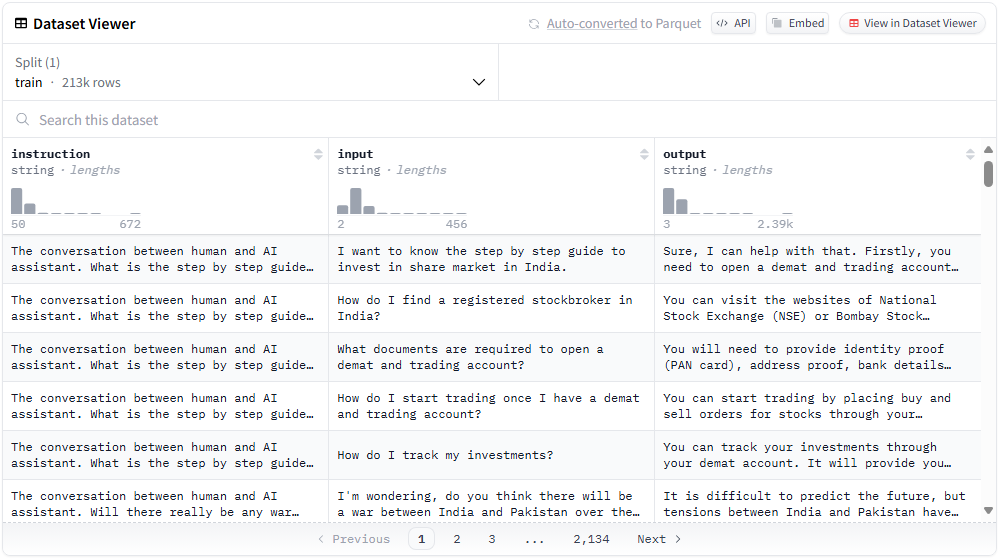
    
- For this example the data will be transformed into chat completion format and the system prompt is overriden with the one given below
    
    **SystemPrompt**
    ```text
    The following is a conversation between a human and an AI assistant. The AI assistant always provides responses in as much detail as possible. The AI assistant will never ask personal information. The AI assistant always declines to engage with topics, questions and instructions related to unethical, controversial, or sensitive issues. Complete the conversation transcript.
    ```
    
    ---

    **Transformed Data**

    ```JSON
    {
    "messages": [
        {
            "role": "system",
            "content": "The following is a conversation between a human and an AI assistant. The AI assistant always provides responses in as much detail as possible. The AI assistant will never ask personal information. The AI assistant always declines to engage with topics, questions and instructions related to unethical, controversial, or sensitive issues. Complete the conversation transcript."
        },
        {
            "role": "user",
            "content": "I want to know the step by step guide to invest in share market in India."
        },
        {
            "role": "assistant",
            "content": "Sure, I can help with that. Firstly, you need to open a demat and trading account with a registered stockbroker."
        },
        {
            "role": "user",
            "content": "How do I find a registered stockbroker in India?"
        },
        {
            "role": "assistant",
            "content": "You can visit the websites of National Stock Exchange (NSE) or Bombay Stock Exchange (BSE) to get a list of registered stockbrokers in India."
        }...
    ]
    }
    ```

In [ ]:
from datasets import load_dataset
from pathlib import Path
import json


def load_hf_dataset(
    dataset_name,
    system_prompt,
    train_sample_size=100,
    val_sample_size=100,
    test_sample_size=100,
    train_split_name="train",
):

    full_dataset = load_dataset(dataset_name)
    train_data = full_dataset[train_split_name]
    full_df = train_data.to_pandas()
    conversations = list(full_df.groupby("instruction", sort=False))
    conversations = conversations[
        : train_sample_size + val_sample_size + test_sample_size
    ]
    all_conversations_chat_format = []
    for instruction, conversation_df in conversations:
        conversation = {"messages": []}
        conversation_df.reset_index(drop=True, inplace=True)
        for i, row in conversation_df.iterrows():
            if i == 0:
                conversation["messages"].append(
                    {"role": "system", "content": system_prompt}
                )
            conversation["messages"].append({"role": "user", "content": row["input"]})
            conversation["messages"].append(
                {"role": "assistant", "content": row["output"]}
            )
        all_conversations_chat_format.append(conversation)
    train_data = all_conversations_chat_format[:train_sample_size]
    val_data = all_conversations_chat_format[
        train_sample_size : train_sample_size + val_sample_size
    ]
    test_data = all_conversations_chat_format[
        train_sample_size
        + val_sample_size : train_sample_size
        + val_sample_size
        + test_sample_size
    ]

    return train_data, val_data, test_data

In [ ]:
# We can define train and test sample sizes here.
train_sample_size = 100
val_sample_size = 100
system_prompt = "The following is a conversation between a human and an AI assistant. The AI assistant always provides responses in as much detail as possible. The AI assistant will never ask personal information. The AI assistant always declines to engage with topics, questions and instructions related to unethical, controversial, or sensitive issues. Complete the conversation transcript."
# Sample notebook using the dataset: https://huggingface.co/datasets/cestwc/conjnli
dataset_name = "twodgirl/baize-quora"


# Note: train_split_name and test_split_name can vary by dataset. They are passed as arguments in load_hf_dataset.
# If val_split_name is None, the below function will split the train set to create the specified sized validation set.
train, val, _ = load_hf_dataset(
    dataset_name=dataset_name,
    system_prompt=system_prompt,
    train_sample_size=train_sample_size,
    val_sample_size=val_sample_size,
)

print("Len of train data sample is " + str(len(train)))
print("Len of validation data sample is " + str(len(val)))

In [ ]:
! mkdir -p data

In [ ]:
train_data_path = Path(f"data/train_quora_{train_sample_size}.jsonl")
valid_data_path = Path(f"data/valid_quora_{val_sample_size}.jsonl")

In [ ]:
with open(train_data_path, "w") as f:
    for row in train:
        f.write(json.dumps(row) + "\n")

with open(valid_data_path, "w") as f:
    for row in val:
        f.write(json.dumps(row) + "\n")

## Prepare data inputs



In [ ]:
train_data = None
train_data_name = "quora_chat_train_data"

train_data = ml_client.data.create_or_update(
    Data(
        path=train_data_path,
        type=AssetTypes.URI_FILE,
        description="Training dataset",
        name=train_data_name,
    )
)

train_data_asset_id = f"azureml://locations/{ai_project.location}/workspaces/{ai_project._workspace_id}/data/{train_data.name}/versions/{train_data.version}"
print(f"{train_data_asset_id=}")

In [ ]:
valid_data = None
valid_data_name = "quora_chat_valid_data"

valid_data = ml_client.data.create_or_update(
    Data(
        path=valid_data_path,
        type=AssetTypes.URI_FILE,
        description="validation dataset",
        name=valid_data_name,
    )
)

valid_data_asset_id = f"azureml://locations/{ai_project.location}/workspaces/{ai_project._workspace_id}/data/{valid_data.name}/versions/{valid_data.version}"
print(f"{valid_data_asset_id=}")

## Configure distillation

**Note:** 
- For each turn in the conversation data, the assistant's response is generated by the teacher model, utilizing the user prompt and the preceding chat history. This synthetic response then replaces the original assistant response in the dataset.
- The distillation process will proceed using the conversation data generated in this manner.

In [ ]:
mlclient_azureml = MLClient(credential, registry_name="azureml")

In [ ]:
distillation_pipeline_name = "oss_distillation_pipeline"
distillation_pipeline_component = mlclient_azureml.components.get(
    name=distillation_pipeline_name
)

In [ ]:
@pipeline
def distillation_pipeline(
    teacher_model_endpoint_name: str,
    system_properties: str,
    input_finetune_model: Input,
    train_file_path: Input,
    validation_file_path: Input = None,
):
    oss_distillation = distillation_pipeline_component(
        teacher_model_endpoint_name=teacher_model_endpoint_name,
        train_file_path=train_file_path,
        validation_file_path=validation_file_path,
        # Finetune
        mlflow_model_path=input_finetune_model,
        model_asset_id=student_model.id,
        system_properties=system_properties,
        ## hyperparams
        learning_rate=2e-5,
        per_device_train_batch_size=1,
        num_train_epochs=3,
        data_generation_task_type="CONVERSATION",
    )

    return {"output_model": oss_distillation.outputs.output_model}

In [ ]:
system_properties = {
    "finetune_oss": "True",
    "model_asset_id": student_model.id,
    "PipelineType": "Finetune",
    "azureml.PipelineType": "Finetune",
    "azureml.ModelName": student_model.name,
    "azureml.original_model_id": student_model.id,
    "azureml.trainingData.assetId": train_data_asset_id,
}

json_str = json.dumps(system_properties).replace(" ", "")

system_properties_b64_encoded = base64.b64encode(json_str.encode("utf-8")).decode(
    "utf-8"
)
print(f"System properties => {system_properties_b64_encoded}")

In [ ]:
train_file_path_input = Input(type="uri_file", path=train_data.path)
validation_file_path_input = Input(type="uri_file", path=valid_data.path)
input_finetune_model = Input(type="mlflow_model", path=student_model.id)
experiment_name = f"distillation-{TEACHER_MODEL_NAME}".replace(".", "-")

finetuning_job = distillation_pipeline(
    teacher_model_endpoint_name=TEACHER_MODEL_ENDPOINT_NAME,
    system_properties=system_properties_b64_encoded,
    input_finetune_model=input_finetune_model,
    train_file_path=train_file_path_input,
    validation_file_path=validation_file_path_input,
)

finetuning_job.properties.update(system_properties)
print(f"job property: {finetuning_job.properties}")

# pipeline_job.identity = UserIdentityConfiguration()
finetuning_job.display_name = f"finetune-{student_model.name}"
finetuning_job.experiment_name = experiment_name
finetuning_job.settings.default_compute_type = "serverless"
finetuning_job.continue_on_step_failure = False
# pipeline_job.settings.force_rerun = True

## Submit pipeline job

In [ ]:
# Submit pipeline job to workspace
ft_job = ml_client.jobs.create_or_update(finetuning_job)
print(f"Submitted job, progress available at {ft_job.studio_url}")

## Consuming the distilled model

Once the above job completes, you should be able to deploy the model and use it for inferencing. To deploy this model, do the following:

* Go to AI Studio
* Navigate to the Fine-tuning tab on the left menu
* In the list of models you see, click on the model which got created from the distillation
* This should take you to the details page where you can see the model attributes and other details
* Click on the Deploy button on top of the page
* Follow the steps to deploy the model